In [39]:
%pylab inline
import lib
lib.cmdstan_path('~/stan/cmdstan')

Populating the interactive namespace from numpy and matplotlib


'/gpfs/homeb/pcp0/pcp0025/stan/cmdstan'

# toy data

We just want to test that model can fit given EI pattern,
where the simplest interesting scenario would be to seizure
initiation, propagation and another node which doesn't partipate.
We'll start with just 3 nodes

In [43]:
w = abs(randn(21, 21)) # np.loadtxt('trec.d/weights.txt')
n = 3
w = w[-n:, -n:]
np.fill_diagonal(w, 0)
w /= w.max()

data = {
     "n": n,
     "ns": 50,
     "T": 10.0,
     "w": w**0.5,
     "ei": np.r_[0.0, 0.3, 1.0],
}
lib.rdump('vep-ode-ei.R', data)

In [44]:
!h=`pwd`;cd $CMDSTAN; make CC=g++ $h/vep-ode-ei; cd $h

make: `/gpfs/homeb/pcp0/pcp0025/stan/vep.stan/vep-ode-ei' is up to date.


In [45]:
%%bash
m=vep-ode-ei
rm $m.*.csv $m.*.out
for i in {1..8}
do
./$m id=$i sample save_warmup=1 num_warmup=200 num_samples=200 \
     data file=vep-ode-ei.R \
     output refresh=1 file=vep-ode-ei.$i.csv &> vep-ode-ei.$i.out &
done

In [68]:
! for i in {1..8}; do tail -n1 vep-ode-ei.$i.out; done

In [34]:
!killall vep-ode-ei

vep-ode-ei: no process found


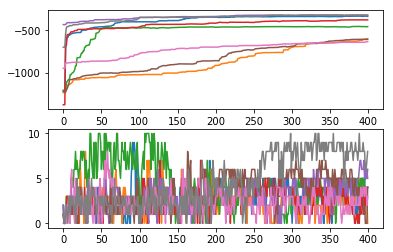

In [69]:
csv = lib.parse_csv('vep-ode-ei.*.csv', merge=False)
subplot(211); [plot(c['lp__']) for c in csv];
subplot(212); [plot(c['treedepth__']) for c in csv];
    

In [72]:
csv = lib.merge_csv_data(*[{k:v[200:] for k,v in _.items()} for _ in csv])

In [73]:
csv = lib.parse_csv('vep-ode-ei.*.csv')
globals().update(csv)
for key, val in csv.items():
    print(key, val.shape)

lp__ (3200,)
accept_stat__ (3200,)
stepsize__ (3200,)
treedepth__ (3200,)
n_leapfrog__ (3200,)
divergent__ (3200,)
energy__ (3200,)
ic_xz (3200, 6)
x0_ (3200, 3)
k_ (3200,)
k (3200,)
x0 (3200, 3)
xz0 (3200, 6)
eih (3200, 3)
xze (3200, 9, 50)


In [74]:
xze = xze.reshape((-1, 3, 3, 50))

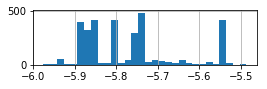

In [75]:
figure(figsize=(4, 1)); hist(log(k), 30); grid(1);

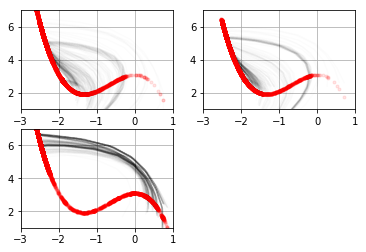

In [76]:
for i in range(3):
    subplot(2, 2, i + 1)
    x = xze[::10, 0, i].T
    z = xze[::10, 1, i].T
    plot(x, z, 'k', alpha=0.01)
    x_ = x.flat[:]
    plot(x, 3.1 - x * x * x - 2 * x * x, 'r.', alpha=0.1)
    axis([-3, 1.0, 1, 7])
    grid(1)